<a href="https://www.kaggle.com/code/muradpitafi/style-transfer-using-vgg19?scriptVersionId=174510544" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

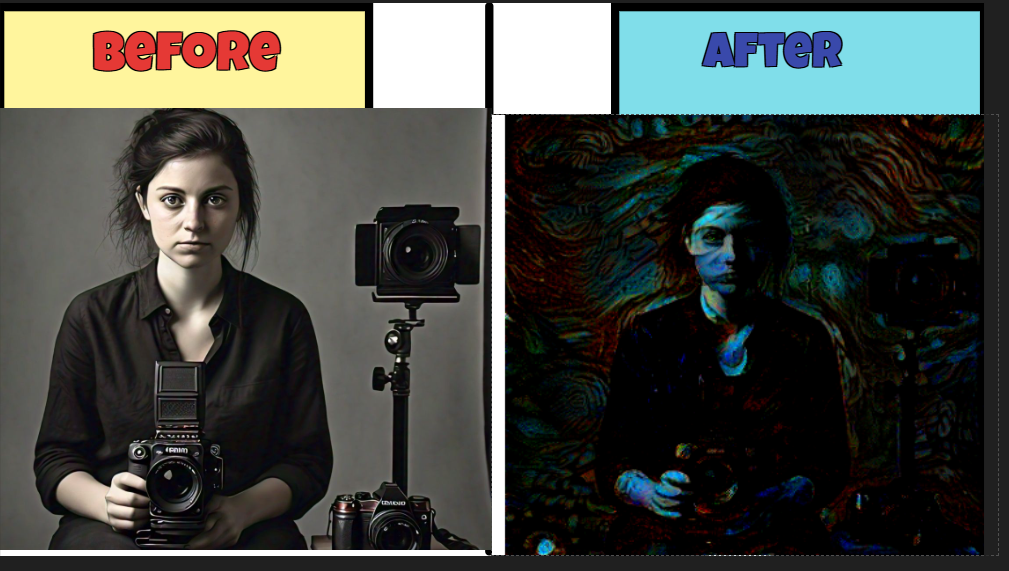

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/content-and-style/WhatsApp Image 2024-04-28 at 22.37.10_fc95bd20.jpg
/kaggle/input/content-and-style/WhatsApp Image 2024-04-28 at 22.40.13_2155e2af.jpg


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import numpy as np
import matplotlib.pyplot as plt

# Set the image size
img_height = 400
img_width = 400
channels = 3

# Define paths to content and style images
content_image_path = '/kaggle/input/content-and-style/WhatsApp Image 2024-04-28 at 22.37.10_fc95bd20.jpg'
style_image_path = '/kaggle/input/content-and-style/WhatsApp Image 2024-04-28 at 22.40.13_2155e2af.jpg'

# Define parameters for neural style transfer
content_weight = 1.0
style_weight = 1.0
total_variation_weight = 1e-6
iterations = 1000
learning_rate = 10.0


2024-04-28 18:00:46.811480: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 18:00:46.811599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 18:00:46.959789: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def load_and_preprocess_image(image_path, target_shape=(img_height, img_width)):
     
    img = load_img(image_path, target_size=target_shape)
     
    img = img_to_array(img)
    
    img = np.expand_dims(img, axis=0)
     
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

content_image = load_and_preprocess_image(content_image_path)
style_image = load_and_preprocess_image(style_image_path)


In [4]:
def get_vgg_model():
     
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(img_height, img_width, channels))
     
    vgg.trainable = False
    
     
    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    
     
    outputs_dict = dict([(layer.name, layer.output) for layer in vgg.layers])
    
    
    model = Model(inputs=vgg.input, outputs=[outputs_dict[layer] for layer in content_layers + style_layers])
    
    return model, content_layers, style_layers

model, content_layers, style_layers = get_vgg_model()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
# Function to compute content loss
def compute_content_loss(content, target):
    return tf.reduce_mean(tf.square(content - target))

# Function to compute style loss
def gram_matrix(x):
    # Compute the Gram matrix
    gram = tf.linalg.einsum('bijc,bijd->cd', x, x) / tf.cast(tf.size(x), tf.float32)
    return gram

def compute_style_loss(style, target):
    style_gram = gram_matrix(style)
    target_gram = gram_matrix(target)
    return tf.reduce_mean(tf.square(style_gram - target_gram))

# Function to compute total variation loss
def compute_total_variation_loss(image):
    # Compute the total variation loss
    loss = tf.reduce_mean(tf.image.total_variation(image))
    return loss


In [6]:
 
generated_image = tf.Variable(content_image)

# Define the optimizer
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

# Extract content and style features from the images
def get_features(image):
    # Forward pass the image through the model
    features = model(image)
    # Separate the features into content and style features
    content_features = features[:len(content_layers)]
    style_features = features[len(content_layers):]
    return content_features, style_features

content_features, _ = get_features(content_image)
_, style_features = get_features(style_image)

# Optimize the generated image
for i in range(iterations):
    with tf.GradientTape() as tape:
        # Forward pass the generated image through the model
        generated_content_features, generated_style_features = get_features(generated_image)
        
        # Compute the content loss
        content_loss = 0
        for j in range(len(content_layers)):
            content_loss += compute_content_loss(content_features[j], generated_content_features[j])
        
        # Compute the style loss
        style_loss = 0
        for j in range(len(style_layers)):
            style_loss += compute_style_loss(style_features[j], generated_style_features[j])
        
        # Compute the total variation loss
        total_variation_loss = compute_total_variation_loss(generated_image)
        
        # Compute the total loss
        total_loss = content_weight * content_loss + style_weight * style_loss + total_variation_weight * total_variation_loss
    
    # Compute the gradients and apply the optimizer
    gradients = tape.gradient(total_loss, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    
    # Print the loss every 100 iterations
    if i % 100 == 0:
        print(f'Iteration {i}: Total Loss: {total_loss:.4f}')


Iteration 0: Total Loss: 977113.9375
Iteration 100: Total Loss: 6900.6021
Iteration 200: Total Loss: 4313.1484
Iteration 300: Total Loss: 3851.5181
Iteration 400: Total Loss: 5202.1216
Iteration 500: Total Loss: 3053.5215
Iteration 600: Total Loss: 2755.6836
Iteration 700: Total Loss: 5323.0713
Iteration 800: Total Loss: 3587.0430
Iteration 900: Total Loss: 26836.8184


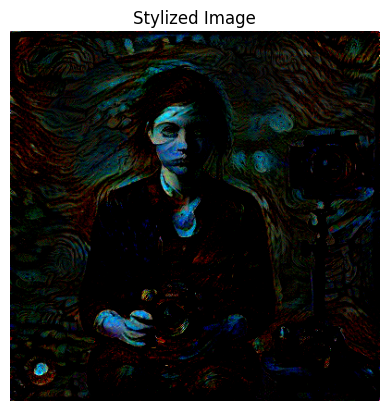

In [7]:
# Convert the generated image back to the original image space
def deprocess_image(image):
    # Clip the pixel values to [0, 255]
    image = np.clip(image, 0, 255)
    # Convert the image from BGR to RGB
    image = image[0].astype(np.uint8)
    return image

# Visualize the stylized image
stylized_image = deprocess_image(generated_image.numpy())
plt.imshow(stylized_image)
plt.title('Stylized Image')
plt.axis('off')
plt.show()
